In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import os
#Manage imports and filepaths
print(os.listdir("/"))

['lib32', 'boot', 'media', 'sbin', 'libx32', 'home', 'tmp', 'proc', 'sys', 'bin', 'srv', 'lib', 'run', 'usr', 'mnt', 'root', 'dev', 'opt', 'lib64', 'etc', 'var', 'openpowerlifting.csv', 'kaggle', 'content', '.dockerenv', 'tools', 'datalab', 'NGC-DL-CONTAINER-LICENSE', 'cuda-keyring_1.0-1_all.deb']


The objective of this study was to analyze data from powerlifting competitions to understand the relationships between various performance metrics (like squat, bench press, and deadlift), their age, weight, and sex, and the overall place of competitors.

In [2]:


openpl = pd.read_csv('/openpowerlifting.csv')
# Import CSV dataset from Kaggle

<ipython-input-2-6a13009ce974>:1: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  openpl = pd.read_csv('/openpowerlifting.csv')


In [3]:
for column in openpl.columns:
        print(column + ", Length: " + str(len(column)))

Name, Length: 4
Sex, Length: 3
Event, Length: 5
Equipment, Length: 9
Age, Length: 3
AgeClass, Length: 8
Division, Length: 8
BodyweightKg, Length: 12
WeightClassKg, Length: 13
Squat1Kg, Length: 8
Squat2Kg, Length: 8
Squat3Kg, Length: 8
Squat4Kg, Length: 8
Best3SquatKg, Length: 12
Bench1Kg, Length: 8
Bench2Kg, Length: 8
Bench3Kg, Length: 8
Bench4Kg, Length: 8
Best3BenchKg, Length: 12
Deadlift1Kg, Length: 11
Deadlift2Kg, Length: 11
Deadlift3Kg, Length: 11
Deadlift4Kg, Length: 11
Best3DeadliftKg, Length: 15
TotalKg, Length: 7
Place, Length: 5
Wilks, Length: 5
McCulloch, Length: 9
Glossbrenner, Length: 12
IPFPoints, Length: 9
Tested, Length: 6
Country, Length: 7
Federation, Length: 10
Date, Length: 4
MeetCountry, Length: 11
MeetState, Length: 9
MeetName, Length: 8


In [4]:
# Dropping any particularly unhelpful columns

Below, data is cleaned by removing insignificant and broken data columns, removing NaN data, and ensuring that only meets that test all 3 primary powerlifting lifts are included. Only raw and raw-adjacent meets will be considered for fairness and coherence.

In [5]:
openpl.drop(columns=['Name', 'AgeClass', 'Division', 'Squat1Kg', 'Squat2Kg', 'Squat3Kg','Squat4Kg', 'Bench1Kg',	'Bench2Kg',	'Bench3Kg', 'Bench4Kg', 'Deadlift1Kg',	'Deadlift2Kg',	'Deadlift3Kg', 'Deadlift4Kg', 'Tested', 'Country', 'Federation', 'Date', 'MeetState', 'MeetName', 'MeetCountry', 'Wilks', 'McCulloch', 'Glossbrenner', 'IPFPoints', 'WeightClassKg'], inplace=True)

In [6]:
openpl.dropna(subset=['Age', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg'], inplace=True)
# After handling NaNs, convert 'Age' to integer
openpl['Age'] = openpl['Age'].astype(int)
# Only include meets that are Raw,  Wrapped, or Strapped, and with SBD
openpl = openpl[openpl['Event'] == 'SBD']
openpl = openpl[openpl['Equipment'].isin(['Raw', 'Wraps', 'Straps'])]
openpl.drop(columns=['Event', 'Equipment'], inplace=True)
#Drop rows where Columns is NaN
openpl.dropna(inplace=True)

<ipython-input-6-a5e51fc516ae>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openpl.drop(columns=['Event', 'Equipment'], inplace=True)
<ipython-input-6-a5e51fc516ae>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  openpl.dropna(inplace=True)


In [7]:
openpl.head(10)

,Sex,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,TotalKg,Place
0,F,29,59.8,105.0,55.0,130.0,290.0,4
1,F,29,58.5,120.0,67.5,145.0,332.5,2
3,F,23,60.0,105.0,72.5,132.5,310.0,3
4,F,45,104.0,140.0,80.0,170.0,390.0,3
5,F,37,74.0,142.5,82.5,145.0,370.0,5
6,F,23,59.8,125.0,70.0,150.0,345.0,1
7,F,35,80.4,140.0,77.5,152.5,370.0,5
8,F,36,108.0,220.0,100.0,200.0,520.0,1
9,F,37,74.8,200.0,95.0,180.0,475.0,1
10,F,34,82.0,185.0,85.0,192.5,462.5,2


Converted all data to comply with numerical datatypes. One-hot data encoded is implemented in order to allow for better categorical sorting with a regression model.

In [8]:
# Encoding categorical data (Sex) using one-hot encoding
df_encoded = pd.get_dummies(openpl, columns=['Sex'], drop_first=True)
print(df_encoded['Place'].unique())

# Check for any non-numeric types in the 'Place' column
non_numeric = df_encoded[df_encoded['Place'].apply(lambda x: not isinstance(x, (int, float)))]
df_encoded = df_encoded[pd.to_numeric(df_encoded['Place'], errors='coerce').notna()]

# Annnnnd other columns too
for column in df_encoded.columns:
    df_encoded[column] = pd.to_numeric(df_encoded[column], errors='coerce')

# Drop any rows with NaN values that resulted from non-convertible entries
df_encoded.dropna(inplace=True)
df_encoded = df_encoded[df_encoded.gt(0).any(axis=1)]


['4' '2' '3' '5' '1' '7' '6' '9' '8' '11' '12' '13' '15' '10' '14' '18'
 '16' '17' '19' '25' '32' '23' '24' '27' '28' '29' '21' '26' '31' '22'
 '30' '20' '33' 'G' '34' '35' '39' '41' '42' '45' '47' '48' '51' '53' '36'
 '37' '38' '40' '43' '44' '46' '49' '50' '52' '54' '55' '56' '57' '58'
 '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71' '72'
 '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86'
 '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99' '100'
 '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111' '112'
 '113' '114' '115' '116' '117' '118' '119' '120']


<ipython-input-8-8b673d32c930>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_encoded[column] = pd.to_numeric(df_encoded[column], errors='coerce')


In [9]:
print(non_numeric)
print(len(df_encoded))


         Age  BodyweightKg  Best3SquatKg  Best3BenchKg  Best3DeadliftKg  \
0         29          59.8         105.0          55.0            130.0   
1         29          58.5         120.0          67.5            145.0   
3         23          60.0         105.0          72.5            132.5   
4         45         104.0         140.0          80.0            170.0   
5         37          74.0         142.5          82.5            145.0   
...      ...           ...           ...           ...              ...   
1423347   65          78.0         215.0         115.0            207.5   
1423348   67          72.7         200.0          70.0            235.0   
1423349   60          73.5         175.0          87.5            190.0   
1423350   55          63.5         110.0          95.0            170.0   
1423351   62          94.4         160.0         100.0            180.0   

         TotalKg Place  Sex_M  
0          290.0     4  False  
1          332.5     2  False  
3  

A multi-linear regression machine learning model was utilized to determined
 the relationship between various performance metrics and placement.

In [10]:
X = df_encoded.drop('Place', axis=1)
y = df_encoded['Place']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Creating the regression model
model = LinearRegression()

# Fitting the model
model.fit(X_train, y_train)

# Predicting the test set results
y_pred = model.predict(X_test)

# Calculating the mean squared error to evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Optionally: Display the coefficients
print('Coefficients:', model.coef_)


Mean Squared Error: 21.511364800644664
Coefficients: [-0.02915084 -0.00236289 -1.06069229 -1.06326061 -1.05705676  1.05736247
  1.25868743]



Listed below are the forms of data visualization to demonstrate the correlation between our data and predicted placements.

**Predicted vs Actual Plot:**

Type: Scatter Plot
Purpose: This plot shows the relationship between the actual places and the predicted places from the regression model. Points along the diagonal line indicate perfect predictions. This visualization helps in assessing the accuracy and effectiveness of the regression model. The closer the points are to the diagonal line, the more accurate the predictions.

**Residuals Plot:**

Type: Scatter Plot
Purpose: This plot displays the residuals (differences between actual and predicted values) on the y-axis against the predicted values on the x-axis. The horizontal line at zero represents no error. The distribution of points around this line helps diagnose issues with the model, such as heteroscedasticity or biases. Ideally, residuals should be randomly dispersed around the horizontal line, indicating that the model's errors are random.

**Distribution of Total Weights:**

Type: Histogram with Kernel Density Estimate (KDE)
Purpose: This plot shows the frequency distribution of the total weights lifted by the competitors, overlaid with a KDE that provides a smooth estimate of the distribution. This visualization helps in understanding the common ranges of total weights and the overall shape of the data distribution (e.g., skewness, modality).

**Relationships between Lifts and Total:**

Type: Scatter Plots within Subplots
Purpose: These plots compare each major lift (squat, bench press, and deadlift) with the total weight lifted, categorized by sex. These visualizations are helpful for identifying trends and correlations between individual lifts and the total weight. Each subplot specifically assesses how changes in one type of lift affect the total weight lifted, with color-coding to distinguish between sexes.

**Correlation Heatmap:**

Type: Heatmap
Purpose: This plot visualizes the correlation matrix of the dataset, providing a color-coded matrix to represent the strength of correlations between all pairs of variables. Darker or more intense colors indicate stronger correlations. This is useful for quickly identifying which variables are most related to others, aiding in understanding dependencies and potential collinearity in the data.

**Boxplots of Total Weights by Age Group:**

Type: Boxplot
Purpose: This plot displays the distribution of total weights lifted, segmented by age group and categorized by sex. Boxplots provide a concise summary of the distribution's median, quartiles, and outliers. This visualization is particularly useful for comparing the central tendencies and variabilities of total weights across different age groups and between sexes.

Mean Squared Error: 21.511364800644664
Coefficients: [-0.02915084 -0.00236289 -1.06069229 -1.06326061 -1.05705676  1.05736247
  1.25868743]


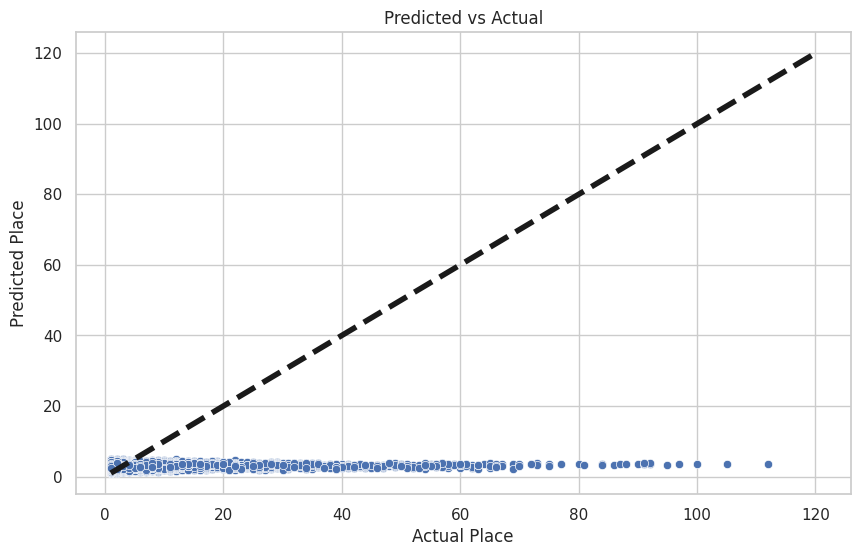

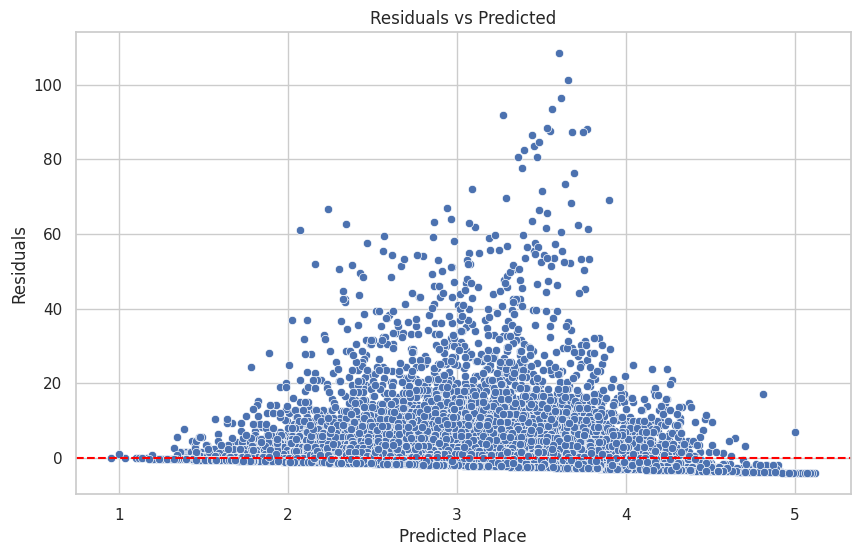

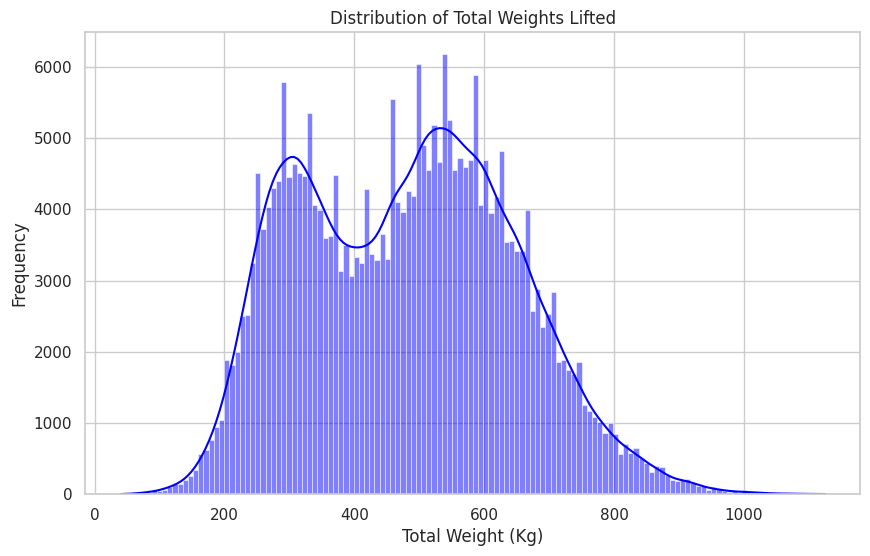

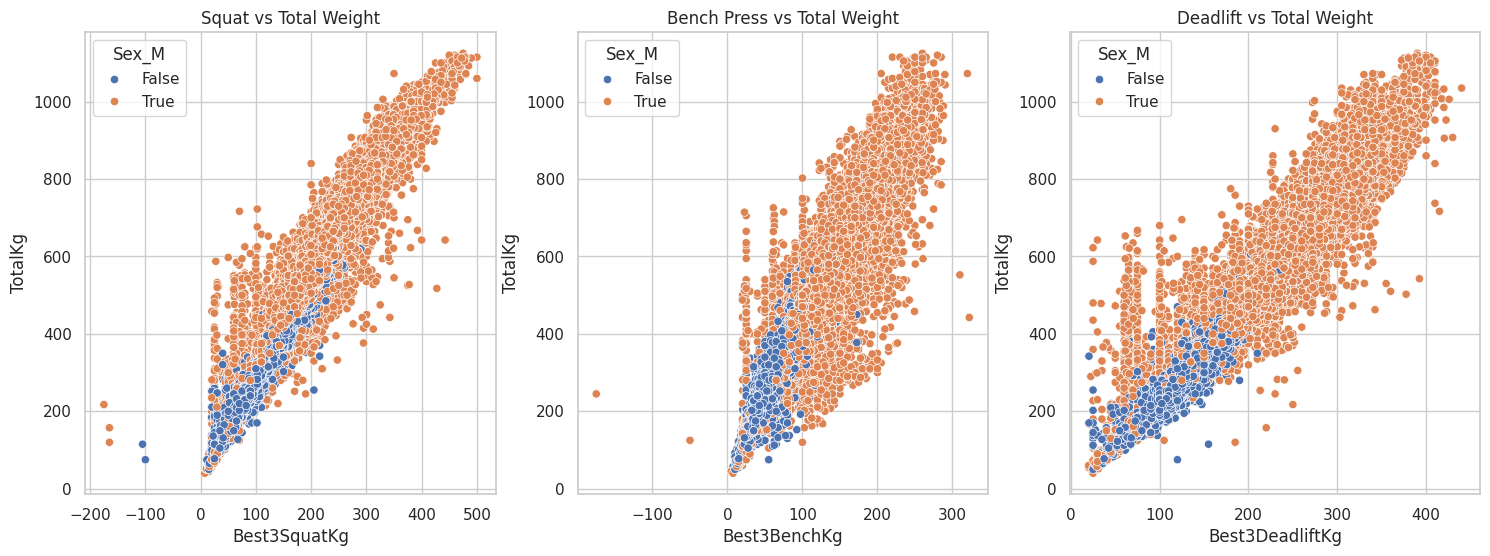

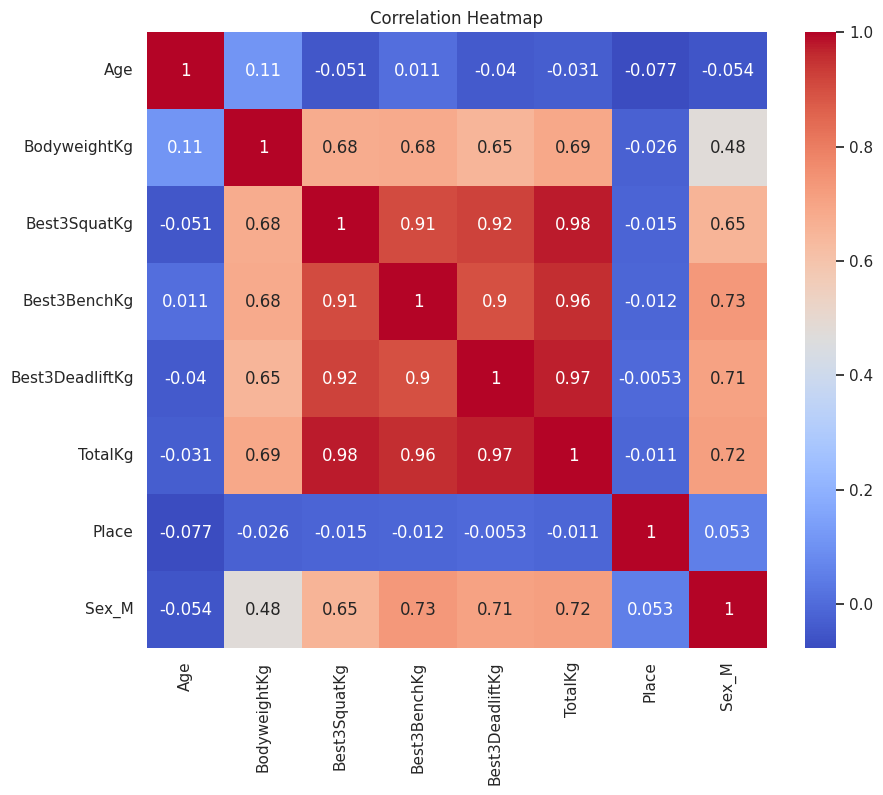

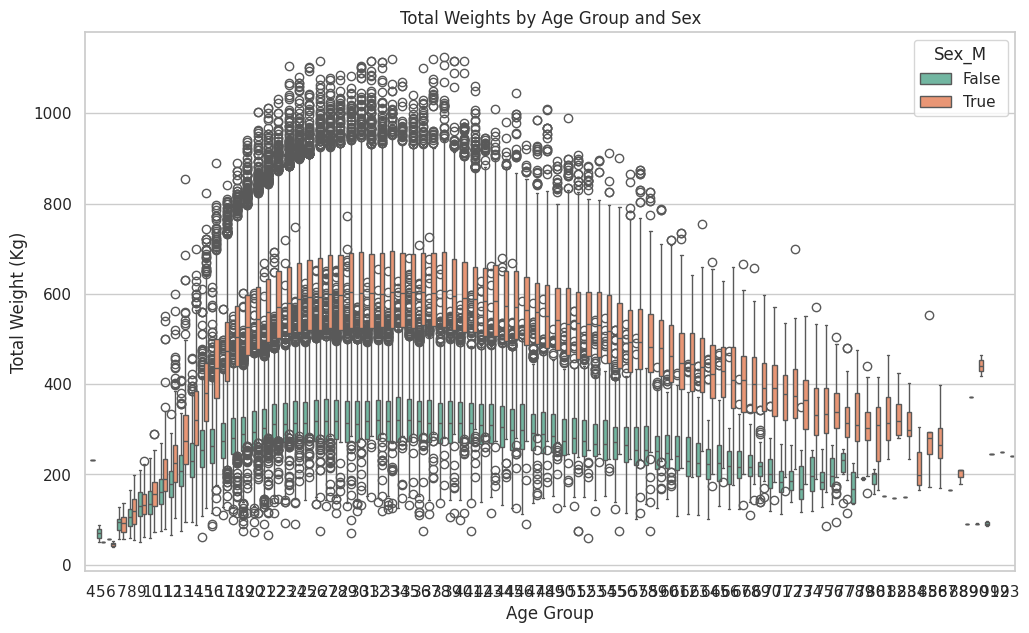

In [11]:
sns.set(style="whitegrid")

print(f'Mean Squared Error: {mse}')
print('Coefficients:', model.coef_)

# Plotting Predicted vs Actual
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)  # Diagonal line for reference
plt.title('Predicted vs Actual')
plt.xlabel('Actual Place')
plt.ylabel('Predicted Place')
plt.show()

# Plotting Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')  # Zero line for reference
plt.title('Residuals vs Predicted')
plt.xlabel('Predicted Place')
plt.ylabel('Residuals')
plt.show()

# 1. Distribution of Total Weights
plt.figure(figsize=(10, 6))
sns.histplot(df_encoded['TotalKg'], kde=True, color="blue")
plt.title('Distribution of Total Weights Lifted')
plt.xlabel('Total Weight (Kg)')
plt.ylabel('Frequency')
plt.show()

# 2. Relationships between Lifts and Total
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.scatterplot(ax=axes[0], data=df_encoded, x='Best3SquatKg', y='TotalKg', hue='Sex_M')
axes[0].set_title('Squat vs Total Weight')
sns.scatterplot(ax=axes[1], data=df_encoded, x='Best3BenchKg', y='TotalKg', hue='Sex_M')
axes[1].set_title('Bench Press vs Total Weight')
sns.scatterplot(ax=axes[2], data=df_encoded, x='Best3DeadliftKg', y='TotalKg', hue='Sex_M')
axes[2].set_title('Deadlift vs Total Weight')
plt.show()

# 3. Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

# 4. Boxplots of Total Weights by Age Group
openpl['Age Group'] = pd.cut(df_encoded['Age'], bins=[0, 24, 34, 44, 54, 64, 100], labels=['18-24', '25-34', '35-44', '45-54', '55-64', '65+'])
plt.figure(figsize=(12, 7))
sns.boxplot(x='Age', y='TotalKg', hue='Sex_M', data=df_encoded, palette="Set2")
plt.title('Total Weights by Age Group and Sex')
plt.xlabel('Age Group')
plt.ylabel('Total Weight (Kg)')
plt.show()

Incorporating additional variables and possibly non-linear models or classification techniques could further improve understanding and prediction of powerlifting performances. Additionally, a larger dataset or data from multiple sources could provide a more generalized model applicable to broader populations.